In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize,root
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,alpha,sigma,df=1):
        self.alpha=alpha
        self.VaR=norm.ppf(alpha)
        aVar=np.array([alpha*(1-alpha),4*(alpha*(1-alpha))**2])/norm.pdf(self.VaR)**2
        print('Reference for a-var (direct, optimal): {}'.format(np.round(aVar,4)))
        
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.oP=lambda x,VaR: self.T(x)*np.abs(1.0*(x[:,0]<VaR)-self.alpha)/(2*self.alpha*(1-self.alpha))
        self.iP=lambda x: mvt.pdf(x=x,loc=np.zeros(dim),shape=sigma**2,df=df)
        self.iS=lambda size: mvt.rvs(size=size,loc=np.zeros(dim),shape=sigma**2,df=df)
        
    def __estimate(self,S,W,name,asym=True):
        self.eVaR=quantile(S[:,0],W,self.alpha)
        err=self.eVaR-self.VaR
        if asym:
            w=W/np.sum(W)
            aVar=np.sum((w*(1.0*(S[:,0]<=self.eVaR)-self.alpha))**2)*W.size
            aVar/=norm.pdf(self.VaR)**2
            aErr=np.sqrt(aVar/W.size)
            ESS=1/np.sum(w**2)
            
            Wf=W*(S[:,0]<self.eVaR)
            wf=Wf/np.sum(Wf)
            ESSf=1/np.sum(wf**2)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}; ESS: {:.0f}/{}; ESS(f): {:.0f}/{}'\
                  .format(name,self.eVaR,err,aVar,aErr,ESS,W.size,ESSf,W.size))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
            
        if any(W<0):
            W[W<0]=0
            self.eVaR=quantile(S[:,0],W,self.alpha)
            err=self.eVaR-self.VaR
            print('(adjusted) {} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
        
    def estimate_IS(self,size):
        self.iS_=self.iS(size)
        self.T_=self.T(self.iS_)
        self.iP_=self.iP(self.iS_)
        W=self.T_/self.iP_
        self.__estimate(self.iS_,W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,self.oP(X,self.VaR))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(X).max()
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.legend(['target','optimal proposal','nonparametric proposal','mixture proposal'])
        elif name=='regression':
            rT=self.T(X)*(1.0*(X[:,0]<self.VaR)-self.alpha)/norm.pdf(self.VaR)
            G=self.G(X)
            oR=self.reg3.coef_.dot(G)/norm.pdf(self.VaR)
            
            ax.plot(x,rT)
            ax.plot(x,oR)
            ax.legend(['target','optimal proposal','mixture proposal',\
                       'regression target','ordinary regression'])
            ax.plot(x,np.zeros_like(x),'k--')
        else:
            ax.legend(['target','optimal proposal','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size):
        p=self.oP(self.iS_,self.eVaR)/self.iP_
        index=np.arange(self.iS_.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=self.iS_[choice]
        self.rSset=self.iS_[list(set(choice))]
        print('resampling rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,size,bdwth='scott'):
        rS1=self.rS[self.rS[:,0]<=self.eVaR]
        rS2=self.rS[self.rS[:,0]>self.eVaR]
        self.kde1=sciKDE(rS1.T,bw_method=bdwth)
        self.kde2=sciKDE(rS2.T,bw_method=bdwth)
        cov1=self.kde1.covariance_factor()*np.cov(rS1.T)
        cov2=self.kde2.covariance_factor()*np.cov(rS2.T)
        print('bdwth 1: {}'.format(np.round(np.sqrt(np.diag(cov1)),2)))
        print('bdwth 2: {}'.format(np.round(np.sqrt(np.diag(cov2)),2)))
        
        tmp=np.copy(self.eVaR)
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=cov1 if loc[0]<=tmp else cov2)
        rate0=rS1.shape[0]/(rS1.shape[0]+rS2.shape[0])
        self.nP=lambda x: rate0*self.kde1.pdf(x.T)+(1-rate0)*self.kde2.pdf(x.T)
        self.nS_=np.vstack([self.kde1.resample(round(rate0*size)).T,self.kde2.resample(size-round(rate0*size)).T])
        
        self.mS_=np.vstack([self.iS_,self.nS_])
        self.T_=np.append(self.T_,self.T(self.nS_))
        self.iP_=np.append(self.iP_,self.iP(self.nS_))
        rate=np.array([self.iS_.shape[0],size])/(self.iS_.shape[0]+size)
        self.mP=lambda x: rate.dot([self.iP(x),self.nP(x)])
        self.mP_=rate.dot([self.iP_,self.nP(self.mS_)])
        
        W=self.T_/self.mP_
        self.__estimate(self.mS_,W,'NIS')
        self.G=lambda x: np.array([self.h(x,loc) for loc in self.rSset[1:]])-self.nP(x)
        
    def estimate_RIS(self):
        self.G_=self.G(self.mS_)
        X=(self.G_/self.mP_).T
        tmp=X/np.linalg.norm(X,axis=0)
        lbd=np.linalg.eigvals(tmp.T.dot(tmp))
        tau=np.sqrt(lbd.max()/lbd)
        print('Condition index: (min {:.4f}, median {:.4f}, mean {:.4f}, max {:.4f}, [>30] {}/{})'\
              .format(tau.min(),np.median(tau),tau.mean(),tau.max(),np.sum(tau>30),tau.size))
        
        y2=self.T_/self.mP_
        y1=y2*(self.mS_[:,0]<=self.eVaR)
        y3=y1-self.alpha*y2
        self.reg1=Linear().fit(X,y1)
        self.reg2=Linear().fit(X,y2)
        self.reg3=Linear().fit(X,y3)
        print('Tail R2: {:.4f}; Body R2: {:.4f}; Overall R2: {:.4f}'\
              .format(self.reg1.score(X,y1),self.reg2.score(X,y2),self.reg3.score(X,y3)))
        
        W2=y2-X.dot(self.reg2.coef_)
        W3=y3-X.dot(self.reg3.coef_)
        aVar=np.sum(W3**2)/(np.sum(W2))**2
        aVar=W2.size*aVar/norm.pdf(self.VaR)**2
        aErr=np.sqrt(aVar/W2.size)
        print('RIS a-var: {:.4f}; a-err: {:.4f}'.format(aVar,aErr))
        
    def estimate_MLE(self,opt=True,NR=True):
        mP=self.mP_
        G=self.G_
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        hessian=lambda zeta: (G/(mP+zeta.dot(G))**2).dot(G.T)/G.shape[1]
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('MLE reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T_/mP)*(1-XX.dot(zeta1))
        print('reg weights: (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.mS_,W,'RIS',asym=False)
        W=self.T_/(mP+zeta1.dot(G))
        print('mle weights (The): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.mS_,W,'MLE(The)',asym=False)
        
        if opt:
            zeta=zeta1 if target(zeta1)!=np.nan else zeta0
            begin=dt.now()
            if NR:
                res=root(lambda zeta: (gradient(zeta),hessian(zeta)),zeta,method='lm',jac=True)
            else:
                cons=({'type':'ineq','fun':lambda zeta: mP+zeta.dot(G),'jac':lambda zeta: G.T})
                res=minimize(target,zeta,method='SLSQP',jac=gradient,constraints=cons,\
                             options={'ftol':1e-8,'maxiter':1000})
            
            end=dt.now()
            print()
            print('Optimization results (spent {} seconds):'.format((end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T_/(mP+zeta.dot(G))
                print('mle weights (Opt): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
                      .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
                self.__estimate(self.mS_,W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

# Run the experiments

==IS==================================================IS==
Reference for a-var (direct, optimal): [4.4656 0.8485]
IS est: -1.5820; err: 0.0628; a-var: 66.5862; a-err: 0.0471; ESS: 698/30000; ESS(f): 113/30000


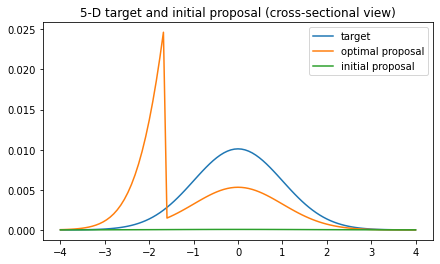

==NIS================================================NIS==
resampling rate: 553/1000
bdwth 1: [0.27 0.7  0.73 0.75 0.75]
bdwth 2: [0.63 0.73 0.72 0.68 0.7 ]
NIS est: -1.6447; err: 0.0001; a-var: 2.2753; a-err: 0.0048; ESS: 29208/100000; ESS(f): 14385/100000


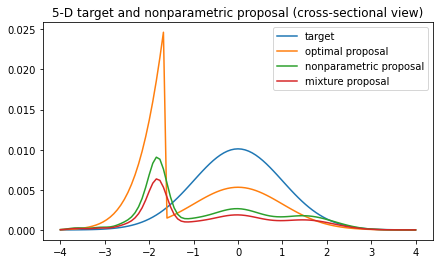

==RIS================================================RIS==
Condition index: (min 1.0000, median 5.0832, mean 7.0525, max 66.1846, [>30] 7/552)
Tail R2: 0.6343; Body R2: 0.8354; Overall R2: 0.8105
RIS a-var: 0.4264; a-err: 0.0021


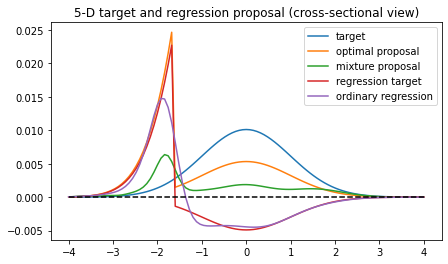

==MLE================================================MLE==
MLE reference:
origin: value: 11.2039; grad: (min -0.2180, mean 0.0048, max 0.1598, std 0.0420)

Theoretical results:
MLE(The) zeta: (min -0.0083, mean -0.0001, max 0.0119, std 0.0013, norm 0.0309)
theory: value: nan; grad: (min -0.4704, mean -0.0139, max 0.2316, std 0.0381)
reg weights: (min 0.0000, mean 0.9976, max 22.5547, [<0] 0/100000)
RIS est: -1.6440; err: 0.0009
mle weights (The): (min -7.6008, mean 1.0025, max 32.7509, [<0] 2/100000)
MLE(The) est: -1.6433; err: 0.0015
(adjusted) MLE(The) est: -1.6437; err: 0.0012

Optimization results (spent 11 seconds):
MLE(Opt) zeta: (min -0.0074, mean -0.0000, max 0.0106, std 0.0013, norm 0.0297)
Dist(zeta(Opt),zeta(The))=0.0037
optimal: value: nan; grad: (min -0.0000, mean -0.0000, max 0.0000, std 0.0000)
mle weights (Opt): (min -2.9840, mean 0.9995, max 24.5709, [<0] 2/100000)
MLE(Opt) est: -1.6440; err: 0.0009
(adjusted) MLE(Opt) est: -1.6440; err: 0.0009


In [3]:
print('==IS==================================================IS==')
mle=MLE(dim=5,alpha=0.05,sigma=4,df=1)
mle.estimate_IS(30000)
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('==NIS================================================NIS==')
mle.resample(1000)
mle.estimate_NIS(70000)
mle.draw_TP(mle.nP,x,'nonparametric')
print('==RIS================================================RIS==')
mle.estimate_RIS()
mle.draw_TP(mle.mP,x,'regression')
print('==MLE================================================MLE==')
mle.estimate_MLE()